# **Модуль А.** Анализ и предобработка данных

## Импортирование библиотек

In [84]:
# для работы с файловой системой
import os

# для работы с раширением tar
import tarfile

# для работы с датафреймами
import pandas as pd
# для работы с датасетами
from datasets import Dataset

# для прослушивания примеров 
from IPython.display import Audio

# для анализа звуковых дорожек
import librosa

# для визуализации результатов
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns

# для построения облака слов
from wordcloud import WordCloud

# для убирания стоп слов
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# для работы с массивами
import numpy as np

# для создания прогресс бара
from tqdm import tqdm

# для работы с GPU
import torch

# для обработки аудиофайлов
import torchaudio.transforms as T
import torchaudio
from scipy import signal

# для регулярных выражений
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alzot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Вспомогательные функции

Все функции реализованны в файле `function.py`

In [85]:
def wave_hist_plot(main_title, df, col, title1, x_label1, y_label1, title2, x_label2, y_label2):    
    # создаем фигуру с двумя subplots 
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # график 1
    df[col].plot(ax=ax1)                           # график   
    ax1.set_title(title1)                          # название
    ax1.set_xlabel(x_label1)                       # ось х
    ax1.set_ylabel(y_label1)                       # ось у

    # график 2
    sns.histplot(df[col], bins=50, kde=True, ax=ax2)        # график
    ax2.set_title(title2)                                   # название
    ax2.set_xlabel(x_label2)                                # ось х
    ax2.set_ylabel(y_label2)                               # ось у

    # заголовок
    plt.suptitle(main_title, fontsize=16)

    # отображение графика
    plt.tight_layout()
    plt.show()

In [86]:
def calculate_snr(y, silence_threshold=0.01):
    # находим тихие участки (шум)
    silent_regions = np.where(np.abs(y) < silence_threshold)[0]
    
    if len(silent_regions) == 0:
        return np.nan  # если нет тихих учатков
    
    # мощность шума (по тихим участкам)
    P_noise = np.mean(y[silent_regions]**2)
    # если мощность шума почти 0
    if P_noise < 1e-10:
        return np.nan
    
    # мощность всего сигнала
    P_signal = np.mean(y**2)
    
    return 10 * np.log10(P_signal / P_noise)

In [87]:
def resample_audio(row, target_sr=16000):
    """
    Передискретизирует аудиомассив из row['array'] 
    с исходной частотой row['sampling_rate'] на target_sr
    """
    # Если частота уже целевая - возвращаем как есть
    if row['sampling_rate'] == target_sr:
        return row['array']
    
    # Передискретизация
    resampled = librosa.resample(
        y=row['array'],
        orig_sr=row['sampling_rate'],
        target_sr=target_sr
    )
    
    # Для сохранения типа данных как в исходном массиве
    return resampled.astype(row['array'].dtype)

In [88]:
stopwords = set(stopwords.words('russian'))

## **Загрузка данных**

In [89]:
# создаем папку для данных
os.makedirs('Data', exist_ok=True)

# получаем пути к архивам с данными
cv_corpus = '../Data/cv-corpus-21.0-delta-2025-03-14-ru.tar.gz'

Открываем архив

In [90]:
# открываем архив используя библиотеку tarfile
with tarfile.open(cv_corpus, 'r:gz') as tar:
    # распаковываем архив
    tar.extractall('Data/cv_corpus')

In [91]:
# получаем путь к папке с данными
data_path = 'Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14/ru/'

In [92]:
# создаем датафрейм
df = pd.read_csv(os.path.join(data_path, 'other.tsv'), sep='\t')[['path', 'sentence']]
# размер датасета
print(f'Кол-во записей: {df.shape[0]}')
# выводим первые 5 строк
df.head()

Кол-во записей: 2940


,path,sentence
0,common_voice_ru_41910911.mp3,"Абай был не только талантливым поэтом, но и уч..."
1,common_voice_ru_41910912.mp3,Гибкая кошка легко взбирается на высокое дерево.
2,common_voice_ru_41910913.mp3,"Мы выступаем за такой Совет Безопасности, в ко..."
3,common_voice_ru_41910914.mp3,Сделать нужно гораздо больше.
4,common_voice_ru_41910915.mp3,"Эти ноты, сливаясь воедино, образуют симфонию,..."


Кол-во файлов с записями - `2940`

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      2940 non-null   object
 1   sentence  2940 non-null   object
dtypes: object(2)
memory usage: 46.1+ KB


Можно заметить, что в датасете нет нулевых значений

Добавление новых колонок в датафрейм

In [94]:
# создаем списки для сбора данных
paths = []                  # полный путь к данным
sampling_rate = []          # частота дискретизации (сэмплирования)
record_duration = []        # длительность записей
arrays = []                 # временной ряд записи
text_length = []            # кол-во символов в транскрипции
snr = []                    # SNR (Signal-to-Noise Ratio)
rms_db = []                 # средняя громкость в dB

# проходимся по каждой строчке в дф
for i in tqdm(range(df.shape[0]), desc='Парсим данные..', unit='record'):
    # получаем путь к записи
    sample_path = os.path.join(data_path, 'clips', df['path'].loc[i])
    # получаем временной ряд и частоту дискретизации
    y, sr = librosa.load(sample_path, sr=None)

    # обновляем списки
    sampling_rate.append(sr)                                                # частота дискретизации
    arrays.append(y)                                                        # временной ряд записи
    record_duration.append(round(len(y)/sr, 2))                             # длительность записи
    text_length.append(len(df['sentence'].loc[i]))                          # кол-во символов
    snr.append(calculate_snr(y))                                            # SNR
    rms_db.append(librosa.amplitude_to_db([np.sqrt(np.mean(y**2))])[0])     # среднюю громкость
    paths.append(sample_path)                                               # путь


Парсим данные..: 100%|██████████| 2940/2940 [02:15<00:00, 21.72record/s]


In [95]:
# добавляем новые колонки в датафрейм
df['path'] = paths
df['record_duration'] = record_duration
df['sampling_rate'] = sampling_rate
df['array'] = arrays
df['text_length'] = text_length
df['snr'] = snr
df['rms_dB'] = rms_db
# выводим первые 3 строки
df.head(3)

,path,sentence,record_duration,sampling_rate,array,text_length,snr,rms_dB
0,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Абай был не только талантливым поэтом, но и уч...",5.04,32000,"[0.0, -2.0297514e-12, -4.6083987e-12, -5.01278...",51,29.652619,-21.792862
1,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Гибкая кошка легко взбирается на высокое дерево.,5.65,32000,"[0.0, 5.2995247e-12, 1.64486e-11, -1.395177e-1...",48,27.797587,-23.426945
2,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Мы выступаем за такой Совет Безопасности, в ко...",7.67,32000,"[0.0, 1.6022399e-11, 1.9621242e-11, 6.006008e-...",107,26.893671,-22.084503


`Передискретизируем` данные с `32000` на `16000`

In [96]:
# Предполагаем, что df - ваш датафрейм
df['array'] = df.apply(resample_audio, axis=1)
df['sampling_rate'] = 16000  # Обновляем частоту дискретизации

In [97]:
df.head()

,path,sentence,record_duration,sampling_rate,array,text_length,snr,rms_dB
0,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Абай был не только талантливым поэтом, но и уч...",5.04,16000,"[-1.4188117e-10, 4.3655746e-11, -8.0035534e-11...",51,29.652619,-21.792862
1,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Гибкая кошка легко взбирается на высокое дерево.,5.65,16000,"[6.91216e-11, -1.0186341e-10, 1.7462298e-10, -...",48,27.797587,-23.426945
2,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Мы выступаем за такой Совет Безопасности, в ко...",7.67,16000,"[0.0, 4.3655746e-11, 8.731149e-11, -2.0372681e...",107,26.893671,-22.084503
3,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Сделать нужно гораздо больше.,3.64,16000,"[-7.2759576e-11, -8.0035534e-11, -5.820766e-11...",29,27.732599,-24.547728
4,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Эти ноты, сливаясь воедино, образуют симфонию,...",6.62,16000,"[7.2759576e-11, -8.367351e-11, 0.0, -7.2759576...",77,23.927073,-25.052473


In [98]:
Audio(df['array'][0], rate=16000)

Все прошло успешно!

## **Анализ данных**

### Математический анализ данных

**Анализ длительностей записей**

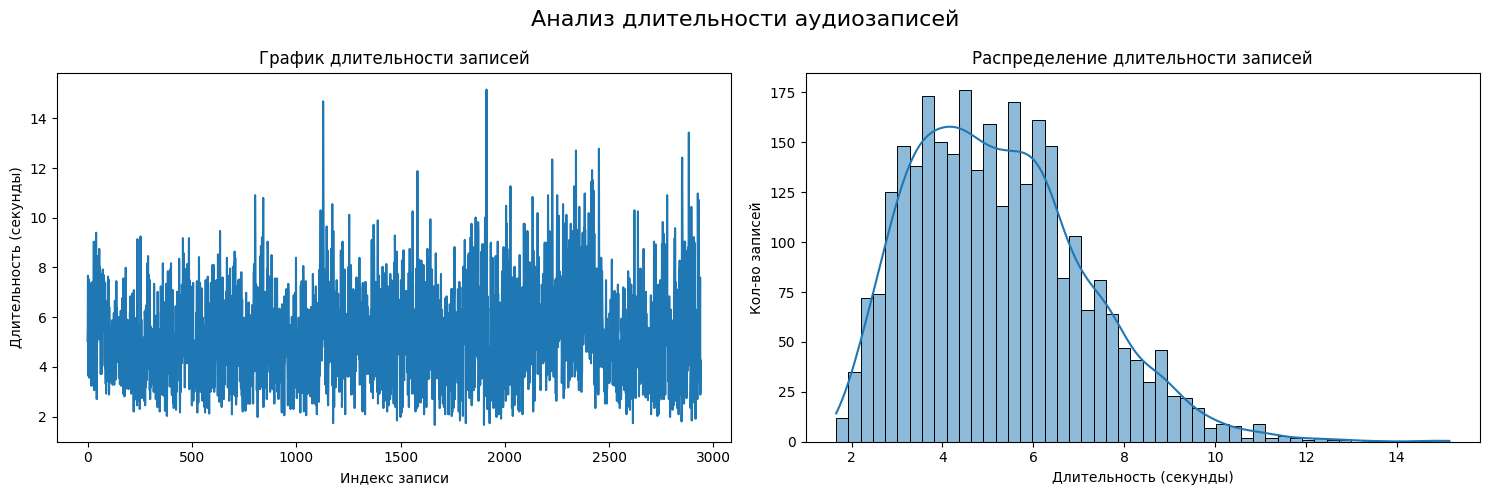

In [99]:
wave_hist_plot('Анализ длительности аудиозаписей', df, 'record_duration',
               'График длительности записей', 'Индекс записи', 'Длительность (секунды)',
               'Распределение длительности записей', 'Длительность (секунды)', 'Кол-во записей')

Исходя из этого графика, можно заметить что `основной массив данных` находится в `диапазоне` от `2 до 8 секунд`. В следствии этого, `отфильтрую` датафрейм по этим значениям:

In [100]:
# логирование
print(f'Размер датафрейма до фильтрации: {df.shape}')

df = df[(df['record_duration'] > 2) & (df['record_duration'] < 8)]
# логирование
print(f'Размер отфильтрованного датафрейма: {df.shape}')

Размер датафрейма до фильтрации: (2940, 8)
Размер отфильтрованного датафрейма: (2678, 8)


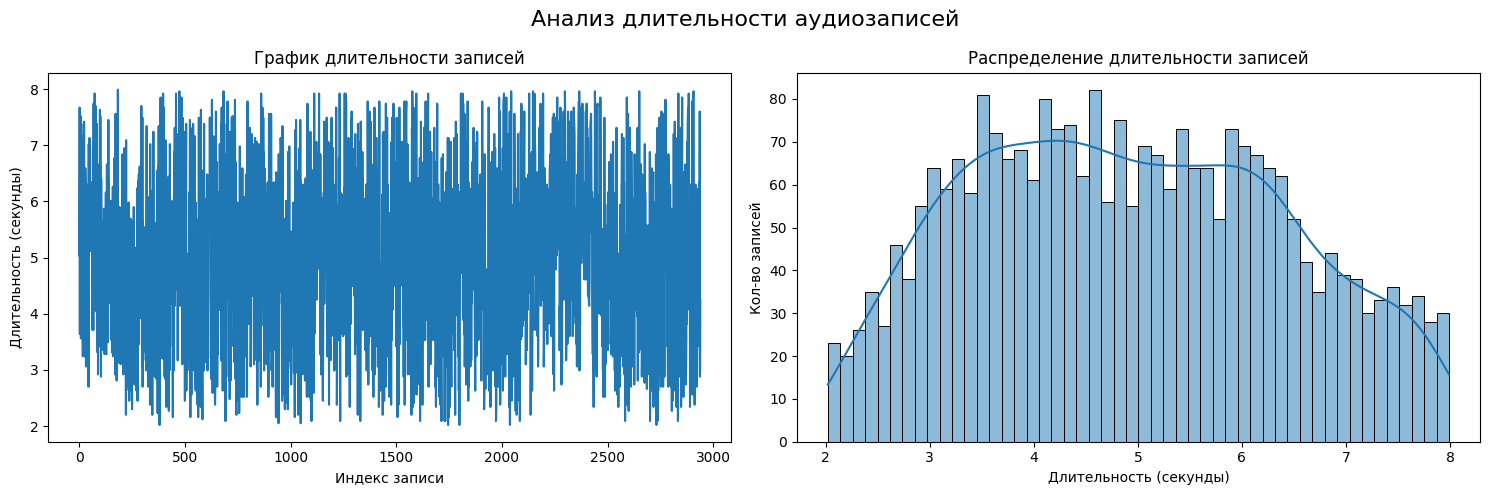

In [101]:
wave_hist_plot('Анализ длительности аудиозаписей', df, 'record_duration',
               'График длительности записей', 'Индекс записи', 'Длительность (секунды)',
               'Распределение длительности записей', 'Длительность (секунды)', 'Кол-во записей')

Теперь все записи находятся в примерно одном диапазоне `по длительности`

In [102]:
print(f"Средняя длительность записи: {df['record_duration'].mean():.2f}")

Средняя длительность записи: 4.91


**Средняя длительность записи:** `4.91 секунда`

Построим **графики распределения** для каждого признака

Text(0, 0.5, 'Плотность')

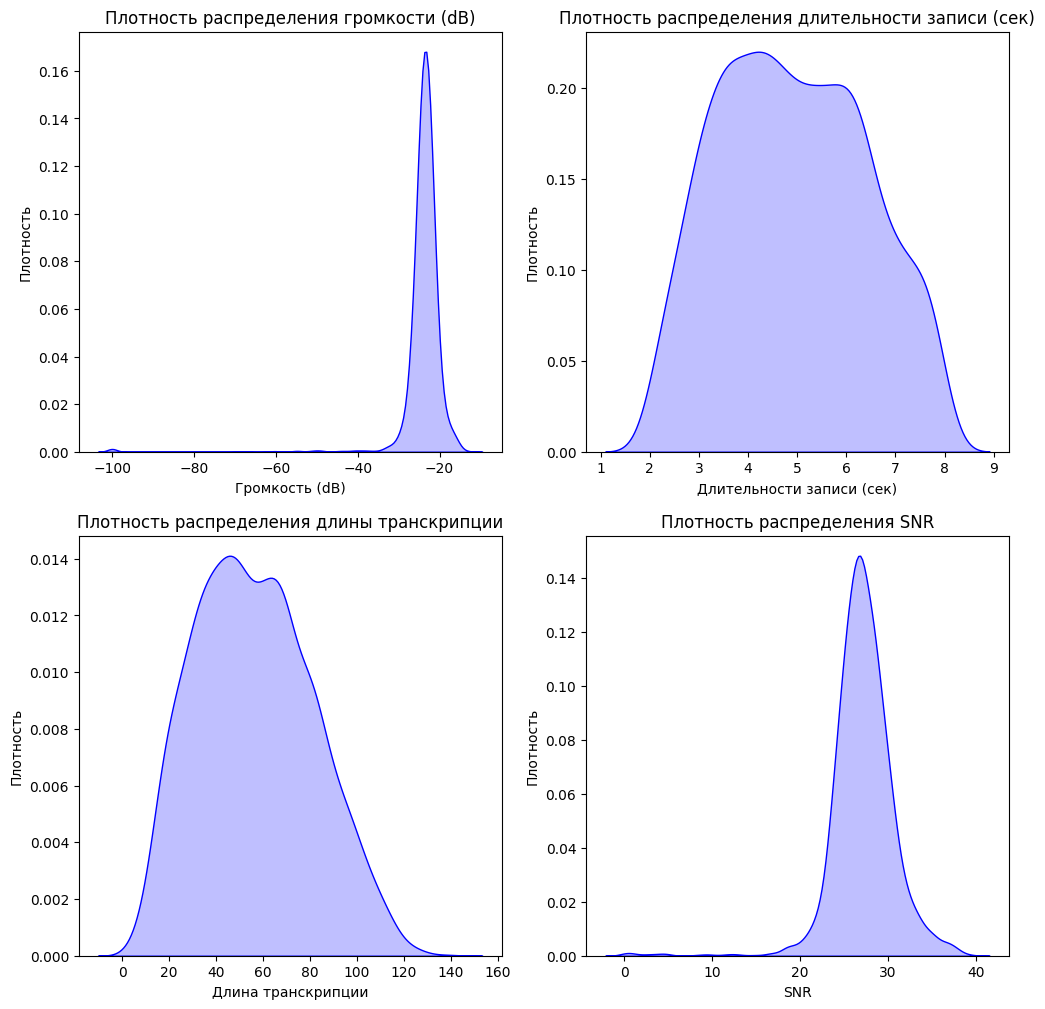

In [103]:
# создаем фигуру с подграфиками
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# график для громкости
sns.kdeplot(df['rms_dB'], fill=True, color='blue', ax=ax[0,0])
ax[0,0].set_title('Плотность распределения громкости (dB)')
ax[0,0].set_xlabel('Громкость (dB)')
ax[0,0].set_ylabel('Плотность')

# график для длительности записи
sns.kdeplot(df['record_duration'], fill=True, color='blue', ax=ax[0,1])
ax[0,1].set_title('Плотность распределения длительности записи (сек)')
ax[0,1].set_xlabel('Длительности записи (сек)')
ax[0,1].set_ylabel('Плотность')

# график для длины транскрипции
sns.kdeplot(df['text_length'], fill=True, color='blue', ax=ax[1,0])
ax[1,0].set_title('Плотность распределения длины транскрипции')
ax[1,0].set_xlabel('Длина транскрипции')
ax[1,0].set_ylabel('Плотность')

# распределение SNR
sns.kdeplot(df['snr'], fill=True, color='blue', ax=ax[1,1])
ax[1,1].set_title('Плотность распределения SNR')
ax[1,1].set_xlabel('SNR')
ax[1,1].set_ylabel('Плотность')

Видно, что большинство `графиков` `распределения` близки к `нормальному`, но `смещены вправо`

### Анализ данных с помощью методов моделирования систем

**Анализ кол-ва символов в транскрипции**

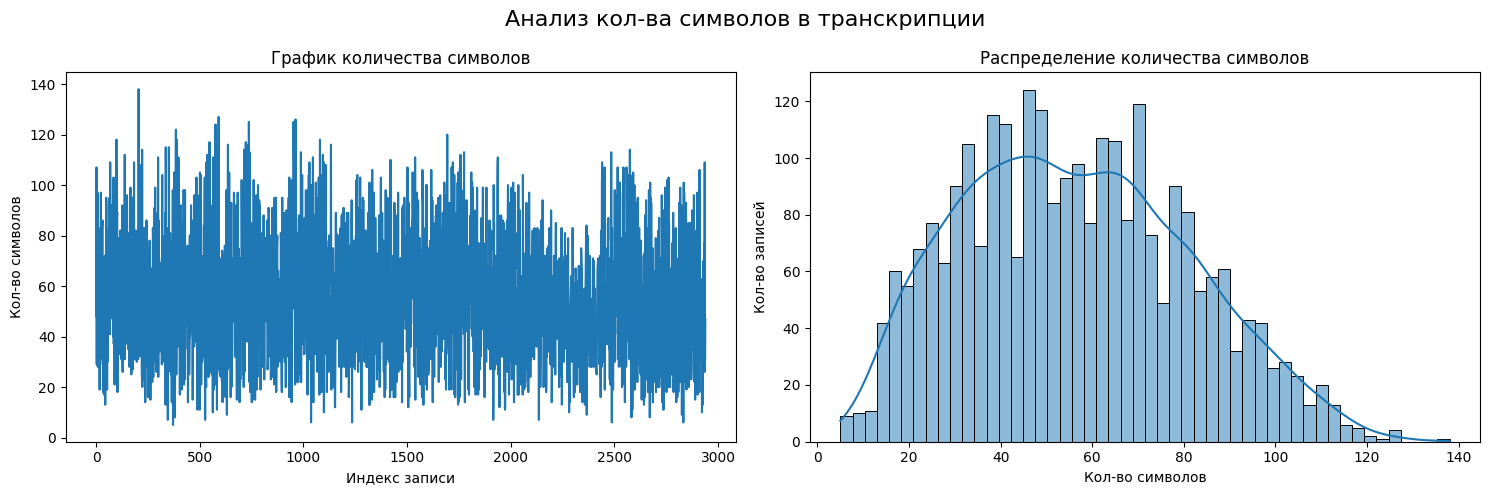

In [104]:
wave_hist_plot('Анализ кол-ва символов в транскрипции', df, 'text_length',
               'График количества символов', 'Индекс записи', 'Кол-во символов',
               'Распределение количества символов', 'Кол-во символов', 'Кол-во записей')

Основной массив данных по кол-ву символов в транскрипции находится в диапазоне от 20 до 100 символов. Отфильтрую датасет:

In [105]:
# логирование
print(f'Размер датафрейма до фильтрации: {df.shape}')

df = df[(df['text_length'] > 20) & (df['text_length'] < 100)]
# логирование
print(f'Размер отфильтрованного датафрейма: {df.shape}')

Размер датафрейма до фильтрации: (2678, 8)
Размер отфильтрованного датафрейма: (2364, 8)


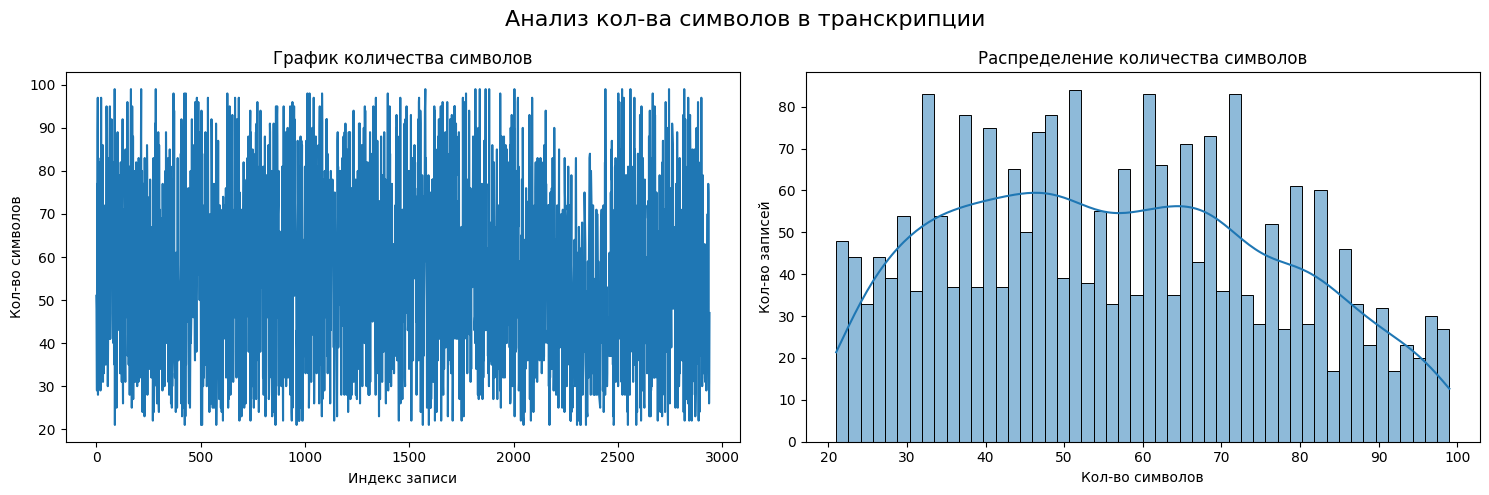

In [106]:
wave_hist_plot('Анализ кол-ва символов в транскрипции', df, 'text_length',
               'График количества символов', 'Индекс записи', 'Кол-во символов',
               'Распределение количества символов', 'Кол-во символов', 'Кол-во записей')

Теперь все записи находятся примерно в одном диапазоне `по кол-ву символов в транскрипции`

In [107]:
print(f"Средняя длина транскрипции: {df['text_length'].mean():.0f}")

Средняя длина транскрипции: 56


**Средняя длина транскрипции:** `56 символов`

**Анализ соотношения длины транскрипции и длительности записи**

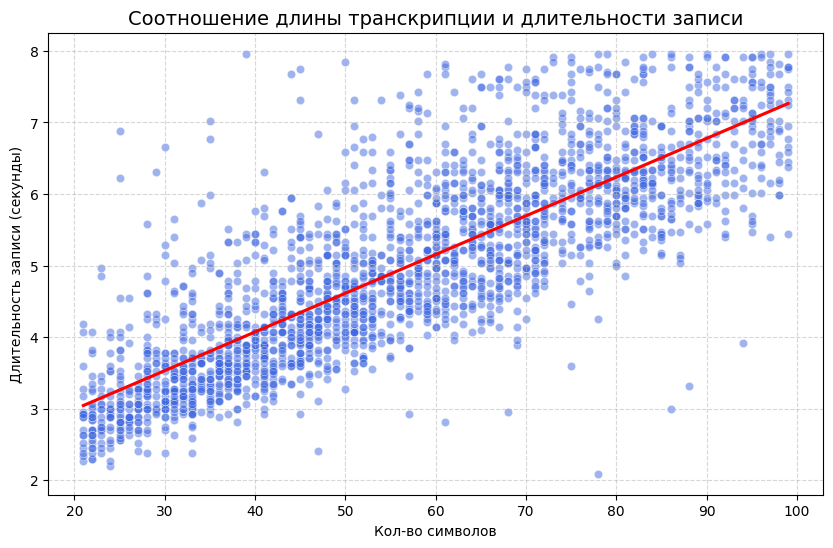

Коэффициент корреляции: 0.8172


In [108]:
# получаем длины транскрипций и записей
tr_lengths = df['sentence'].apply(len)
durations = df['record_duration']

# создаем фигуру 
plt.figure(figsize=(10,6))
sns.scatterplot(x=tr_lengths, y=durations, alpha=.5, color='royalblue')     # создаем диаграмму рассеивания

# добавляем линию тренда
sns.regplot(x=tr_lengths, y=durations, scatter=False, color='red', ci=None)

# настраиваем сам график
plt.title('Соотношение длины транскрипции и длительности записи', fontsize=14)
plt.xlabel('Кол-во символов')
plt.ylabel('Длительность записи (секунды)')
plt.grid(True, linestyle='--', alpha=.5)
# выводим график
plt.show()

# высчитываем саму корреляцию
print(f'Коэффициент корреляции: {np.corrcoef(tr_lengths, durations)[0,1]:.4f}')

**Коэффициент корреляции:** `0.8517`. Это показывает, что между `длиной` `записи` и `транскрипции` есть `сильная положительная связь`

### Анализ природы данных

**Анализ SNR**

**SNR** - `логарифмическое отношение мощности полезного сигнала к мощности шума`

Значение `SNR` от `20 и больше` - хорошее значение

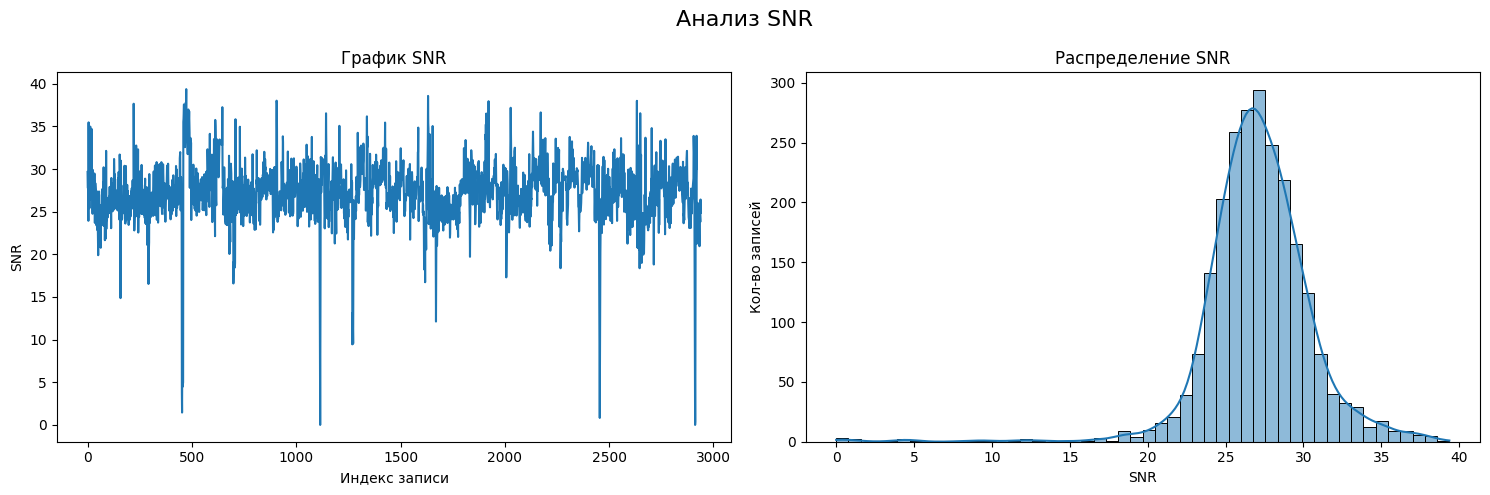

In [109]:
wave_hist_plot('Анализ SNR', df, 'snr',
               'График SNR', 'Индекс записи', 'SNR',
               'Распределение SNR', 'SNR', 'Кол-во записей')

По `SNR` видно `нормальное распределением со смещением вправо`. Отбросим значения `меньше 15`

In [110]:
# логирование
print(f'Размер датафрейма до фильтрации: {df.shape}')

df = df[df['snr']>15]
# логирование
print(f'Размер отфильтрованного датафрейма: {df.shape}')


Размер датафрейма до фильтрации: (2364, 8)
Размер отфильтрованного датафрейма: (2340, 8)


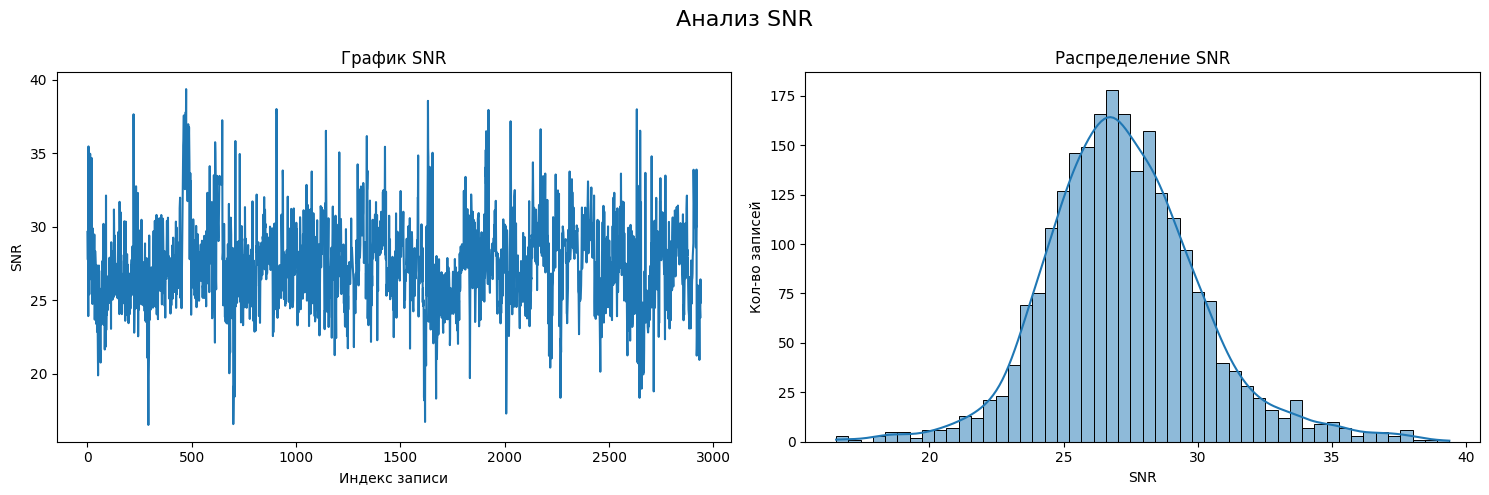

In [111]:
wave_hist_plot('Анализ SNR', df, 'snr',
               'График SNR', 'Индекс записи', 'SNR',
               'Распределение SNR', 'SNR', 'Кол-во записей')

In [112]:
print(f"Среднее значение SNR: {df['snr'].mean():.2f}")

Среднее значение SNR: 27.25


Значение находится в диапазоне `20-30 dB`, что показывает то, что в датасете после фильтрации остались `высококачественные записи` с `низким уровнем шума`

**Анализ громкости**

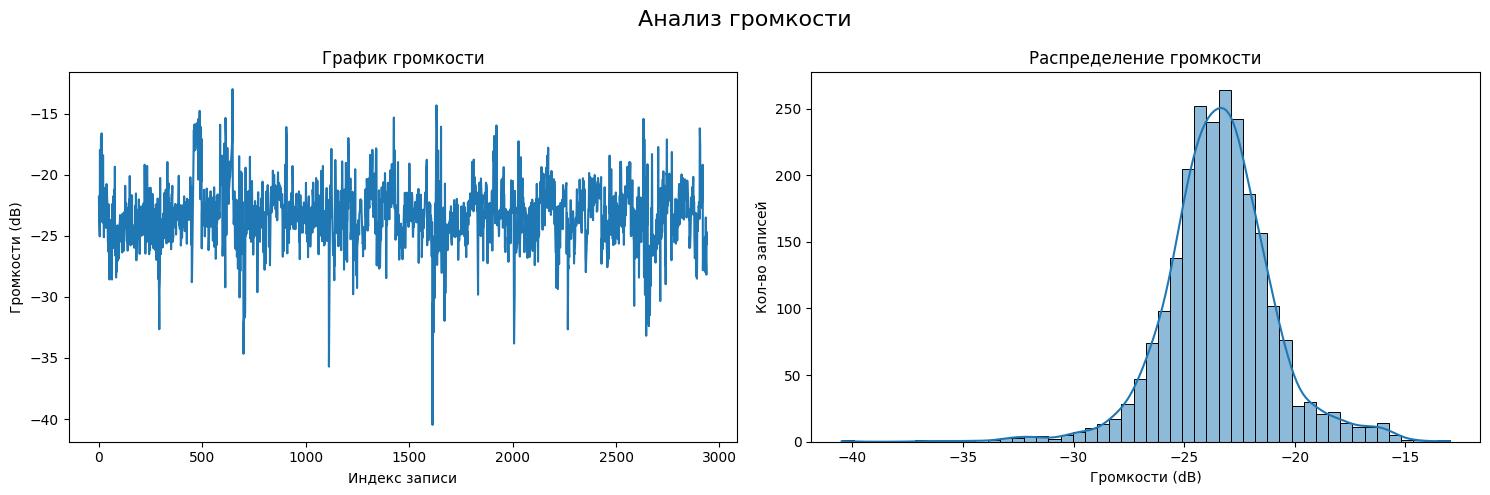

In [113]:
wave_hist_plot('Анализ громкости', df, 'rms_dB',
               'График громкости', 'Индекс записи', 'Громкости (dB)',
               'Распределение громкости', 'Громкости (dB)', 'Кол-во записей')

**Обычный диапазон громкости речи:** `от -40 dB` (очень тихо) до `-10 dB` (очень громко)

Следовательно, и фильтрацию данных стоит производить по данным значениям *(на данный момент график близок к нормальному распределению, но сильно смещен вправо)*

`*как нижнюю границу я возьму значение -35`

In [114]:
# логирование
print(f'Размер датафрейма до фильтрации: {df.shape}')

df = df[(df['rms_dB'] > -35) & (df['rms_dB'] < -10)]
# логирование
print(f'Размер отфильтрованного датафрейма: {df.shape}')

Размер датафрейма до фильтрации: (2340, 8)
Размер отфильтрованного датафрейма: (2337, 8)


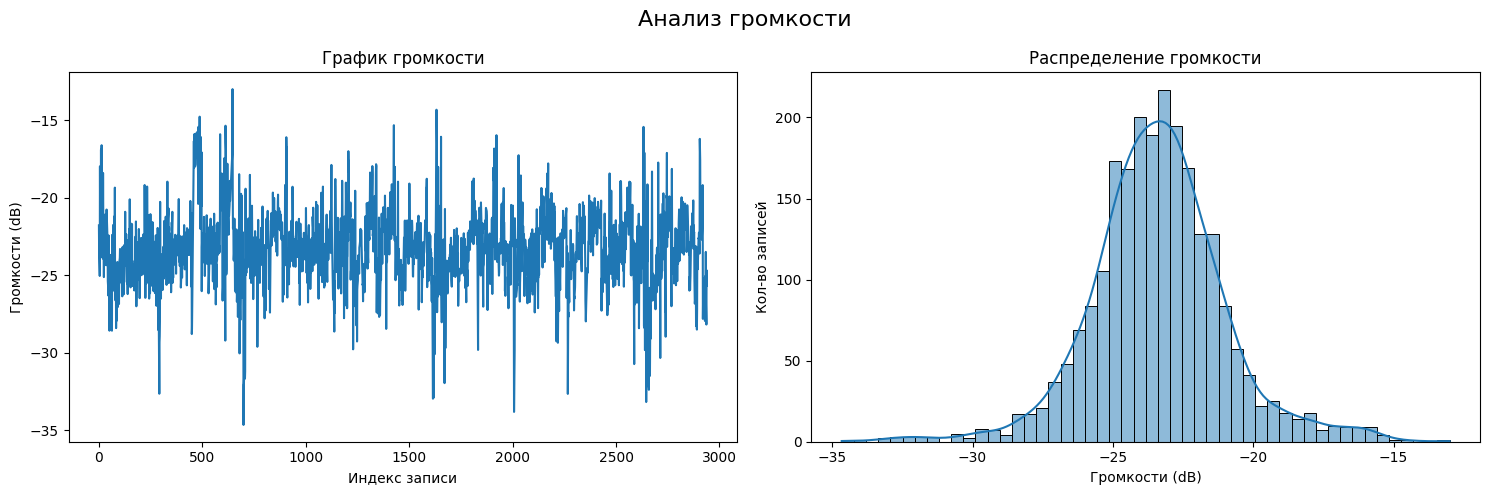

In [115]:
wave_hist_plot('Анализ громкости', df, 'rms_dB',
               'График громкости', 'Индекс записи', 'Громкости (dB)',
               'Распределение громкости', 'Громкости (dB)', 'Кол-во записей')

In [116]:
print(f'Среднее значение громкости по датасету: {df["rms_dB"].mean():.2f}')

Среднее значение громкости по датасету: -23.39


**Среднее значение громкости:** `-23.39`, что говорит о том что записи в датасете имеют `громкий и четкий звук`

Выведу облако слов по всем транскрипциям в датасете

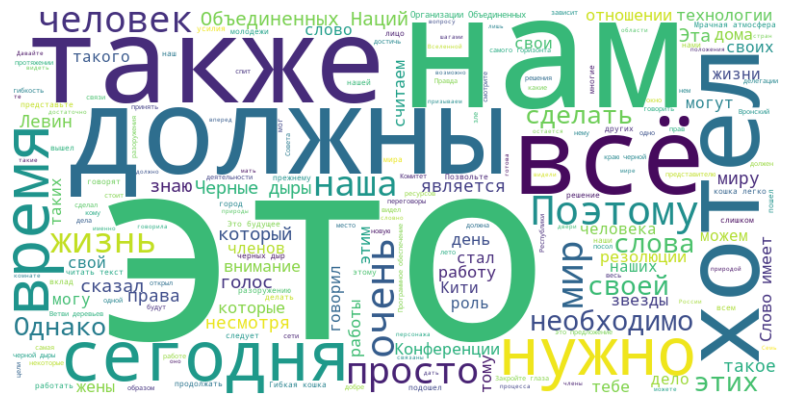

In [117]:
# соединяем все транскрипции в одно предложение
text_data = " ".join(df["sentence"])  

# визуализируем облако слов
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
    colormap="viridis",         # цветовая схема
    stopwords=stopwords         # убираю большинство стоп слов
).generate(text_data)   

# выводим облако слова
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")         # убираем оси
plt.show()


Судя по облаку слов, можно сказать что в датасете `нет четко выделенной темы` текстов\транскрипций

Посчитаем общее время записей в датасете

In [118]:
print(f'Общее время всех записей датасета (в минутах): {sum(df["record_duration"])/60:.2f}')

Общее время всех записей датасета (в минутах): 193.50


**Общая длительность всех записей в датасете:** `193.5 минуты`

## **Предобработка данных**

### Предобработка текста

Для того чтобы обучить модель, надо `обработать входящие данные`. 

Для `обработки текста`, нужно `привести` `все` `к` `нижнему` `регистру` и `токенизировать`

In [119]:
# функция для предобработки текста
def process_text(text: str) -> str:
    '''Ф-я для обработки текста'''
    # приводим к нижнему регистру
    text = text.lower()
    # убираем лишние символы
    text = re.sub(r'[^a-z^А-я0-9\s]', '', text).strip()
    # обработка лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    # разбиваем текст на части сохраняя пробелы
    parts = re.split(r'(\s+)', text)

    # список для токенов
    tokens = []
    # проходимся по каждой части
    for part in parts:
        # если это пробел
        if part.isspace():
            # добавляем заменяющий токен
            tokens.append('_')
        # если не пробел
        elif part:
            for sym in part:

                # сохраняем токен
                tokens.append(sym)
            
    # возврашаем токенизированный текст
    return tokens

In [120]:
test = process_text('Hello  12 Как дела?        ')
print(test)

['h', 'e', 'l', 'l', 'o', '_', '1', '2', '_', 'к', 'а', 'к', '_', 'д', 'е', 'л', 'а']


In [121]:
def built_vocabulary(tokens: list):
    all_tokens = []
    for part in tokens:
        for token in part:
            all_tokens.append(token)

        
    return list(set(all_tokens))

In [122]:
df['tokens'] = df['sentence'].apply(process_text)
df.head()

,path,sentence,record_duration,sampling_rate,array,text_length,snr,rms_dB,tokens
0,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Абай был не только талантливым поэтом, но и уч...",5.04,16000,"[-1.4188117e-10, 4.3655746e-11, -8.0035534e-11...",51,29.652619,-21.792862,"[а, б, а, й, _, б, ы, л, _, н, е, _, т, о, л, ..."
1,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Гибкая кошка легко взбирается на высокое дерево.,5.65,16000,"[6.91216e-11, -1.0186341e-10, 1.7462298e-10, -...",48,27.797587,-23.426945,"[г, и, б, к, а, я, _, к, о, ш, к, а, _, л, е, ..."
3,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Сделать нужно гораздо больше.,3.64,16000,"[-7.2759576e-11, -8.0035534e-11, -5.820766e-11...",29,27.732599,-24.547728,"[с, д, е, л, а, т, ь, _, н, у, ж, н, о, _, г, ..."
4,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Эти ноты, сливаясь воедино, образуют симфонию,...",6.62,16000,"[7.2759576e-11, -8.367351e-11, 0.0, -7.2759576...",77,23.927073,-25.052473,"[э, т, и, _, н, о, т, ы, _, с, л, и, в, а, я, ..."
5,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Квадрат гипотенузы равен сумме квадратов катетов.,5.83,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",49,35.466933,-17.979994,"[к, в, а, д, р, а, т, _, г, и, п, о, т, е, н, ..."


In [123]:
vocabulary = built_vocabulary(df['tokens'])
vocabulary.append('<unk>')
vocabulary.append('<pad>')
print(len(vocabulary))
print(vocabulary)

35
['ж', '_', 'ч', 'а', 'н', 'г', 'ь', 'ш', 'е', 'п', 'э', 'ф', 'к', 'с', 'щ', 'б', 'з', 'и', 'о', 'я', 'х', 'ъ', 'д', 'ы', 'м', 'ю', 'й', 'в', 'р', 'у', 'ц', 'т', 'л', '<unk>', '<pad>']


Строим словарь для токенизации на основе списка:

In [124]:
# индекс
idx = 0
# создаем словарь
token_data = {}

# проходимся по каждому слову
for word in vocabulary:
    # добавляем в словарь
    token_data[word] = idx
    # делаем шаг
    idx+=1

len(token_data)


35

In [125]:
def tokenizer(text: str, vocab: dict = token_data):
    return [vocab.get(token, vocab['<unk>']) for token in process_text(text)]

In [126]:
def back_processing(tokens: list):

    text_data = []
    for token in tokens:
        if token == '_':
            text_data.append(' ')

        else:
            text_data.append(token)

    return ''.join(text_data)

In [127]:
def back_tokenizer(indicies, vocab: dict = token_data):
    inv_vocab = {v:k for k,v in vocab.items()}
    return back_processing(([inv_vocab.get(idx, '<unk>') for idx in indicies]))

In [128]:
text_ids = tokenizer('Привет как дела?')
text_ids

[9, 28, 17, 27, 8, 31, 1, 12, 3, 12, 1, 22, 8, 32, 3]

In [129]:
text = back_tokenizer(text_ids)
text

'привет как дела'

In [130]:
df['token_ids'] = df['sentence'].apply(tokenizer)
df.head()

,path,sentence,record_duration,sampling_rate,array,text_length,snr,rms_dB,tokens,token_ids
0,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Абай был не только талантливым поэтом, но и уч...",5.04,16000,"[-1.4188117e-10, 4.3655746e-11, -8.0035534e-11...",51,29.652619,-21.792862,"[а, б, а, й, _, б, ы, л, _, н, е, _, т, о, л, ...","[3, 15, 3, 26, 1, 15, 23, 32, 1, 4, 8, 1, 31, ..."
1,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Гибкая кошка легко взбирается на высокое дерево.,5.65,16000,"[6.91216e-11, -1.0186341e-10, 1.7462298e-10, -...",48,27.797587,-23.426945,"[г, и, б, к, а, я, _, к, о, ш, к, а, _, л, е, ...","[5, 17, 15, 12, 3, 19, 1, 12, 18, 7, 12, 3, 1,..."
3,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Сделать нужно гораздо больше.,3.64,16000,"[-7.2759576e-11, -8.0035534e-11, -5.820766e-11...",29,27.732599,-24.547728,"[с, д, е, л, а, т, ь, _, н, у, ж, н, о, _, г, ...","[13, 22, 8, 32, 3, 31, 6, 1, 4, 29, 0, 4, 18, ..."
4,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Эти ноты, сливаясь воедино, образуют симфонию,...",6.62,16000,"[7.2759576e-11, -8.367351e-11, 0.0, -7.2759576...",77,23.927073,-25.052473,"[э, т, и, _, н, о, т, ы, _, с, л, и, в, а, я, ...","[10, 31, 17, 1, 4, 18, 31, 23, 1, 13, 32, 17, ..."
5,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Квадрат гипотенузы равен сумме квадратов катетов.,5.83,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",49,35.466933,-17.979994,"[к, в, а, д, р, а, т, _, г, и, п, о, т, е, н, ...","[12, 27, 3, 22, 28, 3, 31, 1, 5, 17, 9, 18, 31..."


сохраняем словарь для токенизации

In [131]:
import json

# Сохранение
with open("Model/text_to_id.json", "w", encoding="utf-8") as f:
    json.dump(token_data, f, ensure_ascii=False, indent=4)

inv_vocab = {v:k for k,v in token_data.items()}

with open("Model/id_to_text.json", "w", encoding="utf-8") as f:
    json.dump(inv_vocab, f, ensure_ascii=False, indent=4)



In [132]:
def extract_mel(y, sr=16000, n_mels=80, n_fft=1024, hop_length=256):
    y = librosa.util.normalize(y)
    y, _ = librosa.effects.trim(y, top_db=20)

    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft,
        hop_length=hop_length, n_mels=n_mels,
        fmin=50, fmax=8000
    )

    mel_spec = np.log(mel_spec + 1e-6)

    return mel_spec


In [133]:
def mel_to_audio(mel_spec, sr=16000, n_fft=1024, hop_length=256, n_mels=80):
    # 1. Отмена логарифмирования
    stft = librosa.feature.inverse.mel_to_stft(
        np.exp(mel_spec) - 1e-6,
        sr=sr,
        n_fft=n_fft,
        fmin=50,
        fmax=8000
    )
    
    audio = librosa.griffinlim(
        stft,
        n_iter=100,
        hop_length=hop_length,
        win_length=n_fft
    )
    
    # 3. Нормализация (чтобы избежать клиппинга)
    audio = librosa.util.normalize(audio) * 0.9
    
    return audio

In [134]:
y, sr = df['array'].loc[0], df['sampling_rate'].loc[0]
print(y)
print(sr)

[-1.4188117e-10  4.3655746e-11 -8.0035534e-11 ...  5.7599635e-07
  5.1849315e-07 -2.8502495e-08]
16000


In [135]:
# Пример
mel_spec_dB = extract_mel(y)
mel_spec_dB

array([[-13.040604 , -10.495331 ,  -7.2823877, ...,  -5.7826304,
         -6.3680997,  -6.28802  ],
       [-11.296524 , -10.004459 ,  -5.7738543, ...,  -3.3790307,
         -3.4025407,  -3.7133574],
       [-11.328768 ,  -7.006546 ,  -3.9856312, ...,  -0.8831096,
         -1.715744 ,  -2.303077 ],
       ...,
       [-13.566031 , -12.643971 , -10.547512 , ..., -11.380468 ,
        -11.989396 , -12.260578 ],
       [-12.816135 , -10.642212 ,  -9.574522 , ..., -12.379046 ,
        -12.447344 , -12.319602 ],
       [-13.253832 , -10.800334 ,  -9.760489 , ..., -13.731651 ,
        -13.561108 , -13.083971 ]], dtype=float32)

In [136]:
Audio(y, rate=sr)

In [137]:
mel_to_audio(mel_spec_dB)

array([-0.00576874, -0.00752681, -0.00758204, ...,  0.01342934,
        0.01329985,  0.013104  ], dtype=float32)

In [138]:
Audio(mel_to_audio(mel_spec_dB), rate=sr)

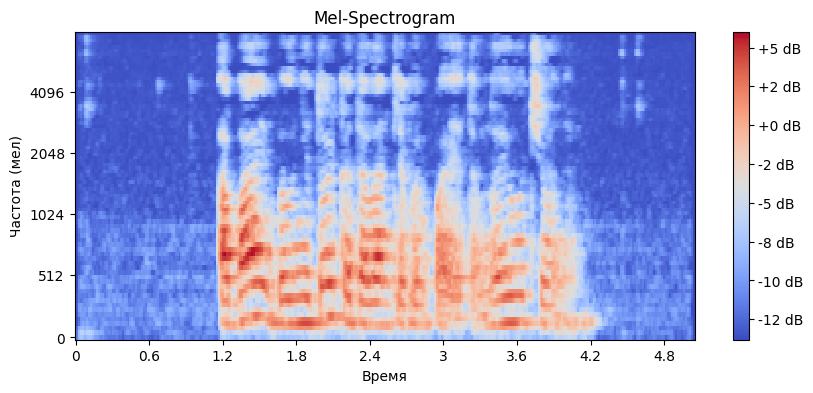

In [56]:
# Визуализация
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_dB, sr=16000, hop_length=256, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram")
plt.ylabel('Частота (мел)')
plt.xlabel('Время')
plt.show()


Вычисляем макс размер временного ряда

In [57]:
arrays_max = max([len(y) for y in df['array']])
arrays_max

127296

<Axes: >

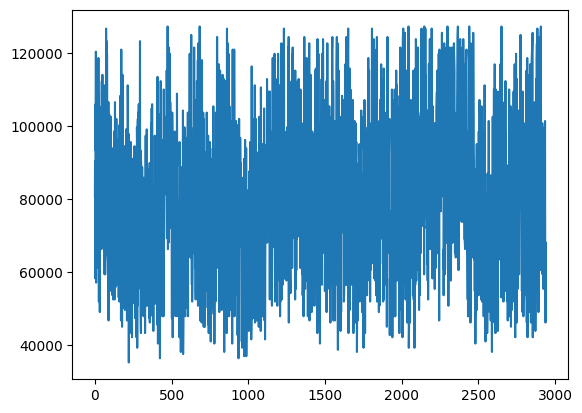

In [58]:
arrays_len = df['array'].apply(len)
arrays_len.plot()

In [59]:
1e-3

0.001

In [60]:
def arrays_padding(y, max_len=arrays_max):
    y = list(y)  # Превращаем в список, если это np.array
    while len(y) < max_len:
        y.append(1e-1)  # Маленькое число вместо 0, чтобы избежать проблем с логарифмом
    return np.array(y)


In [64]:
Audio(arrays_padding(df['array'][0]), rate=16000)

<Axes: >

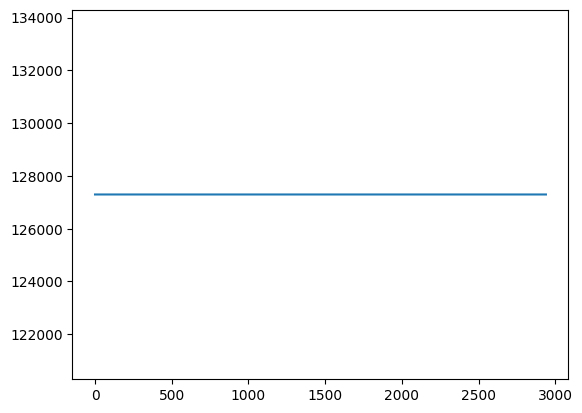

In [65]:
df['array'] = df['array'].apply(arrays_padding)
arrays_len = df['array'].apply(len)
arrays_len.plot()

In [66]:
df['mel_spec'] = df['array'].apply(extract_mel)
df.head(3)

,path,sentence,record_duration,sampling_rate,array,text_length,snr,rms_dB,tokens,token_ids,mel_spec
0,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Абай был не только талантливым поэтом, но и уч...",5.04,16000,"[-1.418811734765768e-10, 4.3655745685100555e-1...",51,29.652619,-21.792862,"[а, б, а, й, _, б, ы, л, _, н, е, _, т, о, л, ...","[3, 15, 3, 26, 1, 15, 23, 32, 1, 4, 8, 1, 31, ...","[[-13.800305818143135, -11.439843118946193, -8..."
1,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Гибкая кошка легко взбирается на высокое дерево.,5.65,16000,"[6.912159733474255e-11, -1.0186340659856796e-1...",48,27.797587,-23.426945,"[г, и, б, к, а, я, _, к, о, ш, к, а, _, л, е, ...","[5, 17, 15, 12, 3, 19, 1, 12, 18, 7, 12, 3, 1,...","[[-13.808701526509054, -12.847779898242456, -1..."
3,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Сделать нужно гораздо больше.,3.64,16000,"[-7.275957614183426e-11, -8.003553375601768e-1...",29,27.732599,-24.547728,"[с, д, е, л, а, т, ь, _, н, у, ж, н, о, _, г, ...","[13, 22, 8, 32, 3, 31, 6, 1, 4, 29, 0, 4, 18, ...","[[-13.813741254347589, -11.622957041259623, -7..."


**Мэл спектограмма** - разновидность спектрограммы, показывает частотное содержание аудиосигнала во времени, но на другой частотной оси. Это перцептивная шкала, которая аппроксимирует нелинейную частотную хар-ку человеческого уха

Теперь вы можете увидеть, как выглядит входной аудиосигнал для модели `Whisper` после `препроцессинга`.

Сохраняю подготовленный датасет для дальнейшего обучения модели

In [67]:
df = df.reset_index(drop=True)
df.head(3)

,path,sentence,record_duration,sampling_rate,array,text_length,snr,rms_dB,tokens,token_ids,mel_spec
0,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,"Абай был не только талантливым поэтом, но и уч...",5.04,16000,"[-1.418811734765768e-10, 4.3655745685100555e-1...",51,29.652619,-21.792862,"[а, б, а, й, _, б, ы, л, _, н, е, _, т, о, л, ...","[3, 15, 3, 26, 1, 15, 23, 32, 1, 4, 8, 1, 31, ...","[[-13.800305818143135, -11.439843118946193, -8..."
1,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Гибкая кошка легко взбирается на высокое дерево.,5.65,16000,"[6.912159733474255e-11, -1.0186340659856796e-1...",48,27.797587,-23.426945,"[г, и, б, к, а, я, _, к, о, ш, к, а, _, л, е, ...","[5, 17, 15, 12, 3, 19, 1, 12, 18, 7, 12, 3, 1,...","[[-13.808701526509054, -12.847779898242456, -1..."
2,Data/cv_corpus/cv-corpus-21.0-delta-2025-03-14...,Сделать нужно гораздо больше.,3.64,16000,"[-7.275957614183426e-11, -8.003553375601768e-1...",29,27.732599,-24.547728,"[с, д, е, л, а, т, ь, _, н, у, ж, н, о, _, г, ...","[13, 22, 8, 32, 3, 31, 6, 1, 4, 29, 0, 4, 18, ...","[[-13.813741254347589, -11.622957041259623, -7..."


In [68]:
token_data.get('<pad>')

34

In [69]:
token_ids_max_length = max([len(token_ids) for token_ids in df['token_ids']])
token_ids_max_length

99

In [70]:
def token_padding(token_ids: list, vocab: dict = token_data, max_len: int = 99):
    while len(token_ids) != max_len:
        token_ids.append(vocab.get('<pad>'))


In [71]:
lens_tokens = df['token_ids'].apply(len)
lens_tokens

0       49
1       47
2       28
3       73
4       48
        ..
2332    73
2333    37
2334    25
2335    30
2336    46
Name: token_ids, Length: 2337, dtype: int64

In [72]:
max_length = max([spec.shape[1] for spec in df['mel_spec']])
max_length

498

<Axes: >

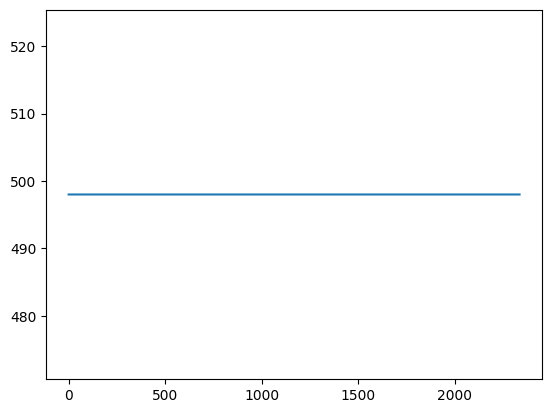

In [73]:
spec_len = df['mel_spec'].apply(lambda x: x.shape[1])
spec_len.plot()

In [74]:
Audio(df['array'][0], rate=16000)

In [76]:
df['token_ids'].apply(token_padding)

0       None
1       None
2       None
3       None
4       None
        ... 
2332    None
2333    None
2334    None
2335    None
2336    None
Name: token_ids, Length: 2337, dtype: object

In [77]:
audio_check = mel_to_audio(df['mel_spec'][0])
Audio(audio_check, rate=16000)

In [80]:
df.columns

Index(['path', 'sentence', 'record_duration', 'sampling_rate', 'array',
       'text_length', 'snr', 'rms_dB', 'tokens', 'token_ids', 'mel_spec'],
      dtype='object')

In [82]:
df = df[['token_ids', 'mel_spec']]
df.head()

,token_ids,mel_spec
0,"[3, 15, 3, 26, 1, 15, 23, 32, 1, 4, 8, 1, 31, ...","[[-13.800305818143135, -11.439843118946193, -8..."
1,"[5, 17, 15, 12, 3, 19, 1, 12, 18, 7, 12, 3, 1,...","[[-13.808701526509054, -12.847779898242456, -1..."
2,"[13, 22, 8, 32, 3, 31, 6, 1, 4, 29, 0, 4, 18, ...","[[-13.813741254347589, -11.622957041259623, -7..."
3,"[10, 31, 17, 1, 4, 18, 31, 23, 1, 13, 32, 17, ...","[[-13.814922695056433, -12.708897850124652, -9..."
4,"[12, 27, 3, 22, 28, 3, 31, 1, 5, 17, 9, 18, 31...","[[-13.815510557964274, -13.815510557964274, -1..."


In [83]:
df.to_hdf('Dataset/dataset.h5', key='df', mode='w')

C:\Users\alzot\AppData\Local\Temp\ipykernel_22832\1648935057.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['token_ids', 'mel_spec'], dtype='object')]

  df.to_hdf('Dataset/dataset.h5', key='df', mode='w')


In [ ]:
# TODO 
# - потоковую загрузку данных (для контроля памяти)